### In this Part Iam going to work with Teamperature Data to predict the average global land and ocean temperature using over 100 years of past weather data.

In [56]:
# Importation 
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [57]:
#Read in GlobalTeamperatures Dataset
globaltemp = pd.read_csv("GlobalTemperatures.csv")
#Print Dataframe shape
globaltemp.shape
globaltemp.columns

Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')

In [58]:
#Identify Anomalies/ Missing Data
globaltemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


In [59]:
#find the total amount of missing values in each column
globaltemp.isnull().sum()

dt                                              0
LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

# Data Preparation

In [60]:
#Apply function to eatch column to convert from object to float
def convertTemp(x):
    return float(x)



In [61]:
def wrangle(df):
    
    df = df.copy()
    
    #Cleaning the dataset from unused column
    df = df.drop(columns=['LandAverageTemperatureUncertainty','LandMaxTemperatureUncertainty','LandMinTemperatureUncertainty','LandAndOceanAverageTemperatureUncertainty'], axis=1)
    #Convert Teamperature Data
    df['LandAverageTemperature'] = df['LandAverageTemperature'].apply(convertTemp)
    df['LandMaxTemperature']=df ['LandMaxTemperature'].apply(convertTemp)
    df['LandMinTemperature']=df ['LandMinTemperature'].apply(convertTemp)
    df['LandAndOceanAverageTemperature']=df ['LandAndOceanAverageTemperature'].apply(convertTemp)
    
    #Convert dt Column to Datetime
    df["dt"] = pd.to_datetime(df["dt"])
    df["Month"]=df["dt"].dt.month
    df["Year"]=df["dt"].dt.year
    df = df.drop("dt", axis=1)
    df= df.drop("Month", axis=1)
    df=df[df.Year >= 1950]
    
    #St index to YearColumn 
    df = df.set_index(['Year'])
    
    #drop NaN values
    df= df.dropna()
    return df


In [62]:
#Apply wrangle Function 
globaltemp = wrangle(globaltemp)

In [63]:
#Print The 5th first Columns to show Modification
globaltemp.head()

,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature
Year,,,,
1950,2.008,7.611,-3.622,13.311
1950,2.721,8.475,-3.013,13.554
1950,5.247,11.173,-0.693,14.296
1950,8.123,14.157,2.043,15.093
1950,11.297,17.252,5.421,16.033


In [64]:
#print the shape
globaltemp.shape

(792, 4)

In [65]:
#Show if still have some null values 
globaltemp.isnull().sum()

LandAverageTemperature            0
LandMaxTemperature                0
LandMinTemperature                0
LandAndOceanAverageTemperature    0
dtype: int64

# Quick Correlation Visualization

For understanding of how related each column is to each other

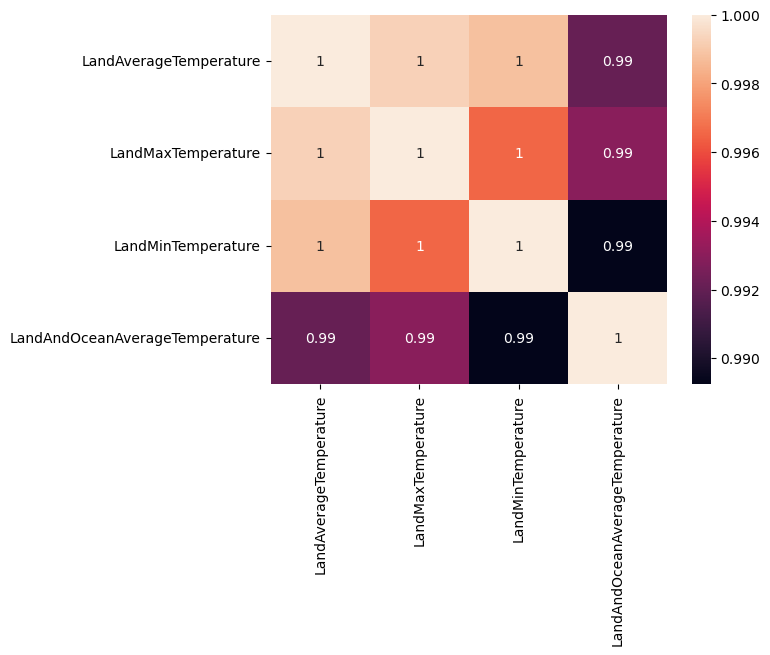

In [66]:
import seaborn as sns 
corrMatrix = globaltemp.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

The columns we chose to keep moving forward are HIGHLY correlated to one another. So we should have pretty strong & positive predictions just from glancing at this plot.

## Separating The Target data From The Features

In [67]:
#Target Vector
Y = globaltemp['LandAndOceanAverageTemperature']

#Feature Matrix
X = globaltemp[['LandAverageTemperature','LandMaxTemperature','LandMinTemperature']]

## Train Test Split

In [68]:
# train Test The X fetures & Y target
from sklearn.model_selection import train_test_split

X_train, X_val,Y_train, Y_val = train_test_split(X,Y, test_size=0.25, random_state=42)

#visualization the split 
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(594, 3)
(198, 3)
(594,)
(198,)


### Establish Baseline Mean Absolute Error

Before make an evaluate predictions, I need to establish a baseline, a sensible measure that I hope to beat with The model. If the model cannot improve upon the baseline, then it will be a failure and I should try a different model or admit that machine learning is not right for My problem.

In [69]:
from sklearn.metrics import mean_absolute_error
y_pred =[Y_train.mean()]* len(Y_train)
print('Baseline MAE:', round(mean_absolute_error(Y_train, y_pred),5))

Baseline MAE: 1.09719


 If I can’t beat an average error of 2 degrees, then I need to rethink my approach!.

# Train Model 

After all the work of data preparation, creating and training the model is pretty simple using scikit-learn. For this problem, I could try a multitude of models, but in this situation, I am going to use two different models; a Linear Regression Model and a Random Forest Regressor Model.

### Linear Regression Model

Linear regression is a statistical approach that models the relationship between input features and output. My goal here is to predict the value of the output based on the input features

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lm = make_pipeline( StandardScaler(), LinearRegression(),)

lm.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

### Random Forest Regressor Model

The basic idea behind bagging is to combine multiple decision trees in determining the final output rather than relying on individual decision trees.

In [71]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor

forestModel = make_pipeline(SelectKBest(k="all"), StandardScaler(), RandomForestRegressor(n_estimators=100, max_depth=50, random_state=77, n_jobs=-1))

forestModel.fit(X_train, Y_train)

Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=50, n_jobs=-1,
                                       random_state=77))])

## Make Predictions on the Testset

Now the model has been trained to learn the relationships between the features and the targets. 

In [72]:
# Linear Regression MAE
print('Linear Regression Training MAE :', round(mean_absolute_error(Y_train, lm.predict(X_train)),5))
print('Linear Regression Test MAE :', round(mean_absolute_error(Y_val, lm.predict(X_val)),5))


Linear Regression Training MAE : 0.12048
Linear Regression Test MAE : 0.11795


In [73]:
# Random Forest Regressor MAE
print('random Forest Regressor Training MAE :',mean_absolute_error(Y_train, forestModel.predict(X_train)))
print('Linear forest Regressior Test MAE :', mean_absolute_error(Y_train, forestModel.predict(X_train)))


random Forest Regressor Training MAE : 0.036279326599326464
Linear forest Regressior Test MAE : 0.036279326599326575


###### The average temperature prediction estimate is off by 0.12 degrees in the Linear Regression MAE and 0.036 for the Random Forest MAE. That is almost a 1-degree average improvement over the baseline of 1.09 degrees.

## Determine Performance Metrics

### Linear Regression Test/Train Accuracy:

In [74]:
y_pred = lm.predict(X_val)
errors = abs(y_pred - Y_val)
#Calculate mean absolute precentage error (MAPE)
mape = 100* (errors / Y_train)

#Calculate and Display Accuracy 
accuracy = 100 - np.mean(mape)
print('Linear ragression Model Prediction Accuracy:', round(accuracy, 2),'%.')

Linear ragression Model Prediction Accuracy: 99.24 %.


### Random Forest Regressor Train/Test Accuracy:

In [75]:
Errors = abs(y_pred - Y_val)
fmape = 100*(Errors / Y_train)
faccuracy = 100 - np.mean(fmape)
print('Forest ragressor Model Prediction Accuracy:', round(faccuracy, 2),'%.')

Forest ragressor Model Prediction Accuracy: 99.24 %.


#### Let’s see if we have any gains in our prediction accuracy score and MAE:

In [77]:
from sklearn.model_selection import RandomizedSearchCV
params = {'selectkbest__k': range(5)}
rs = RandomizedSearchCV(forestModel, param_distributions = params,
                       n_iter=5,
                       n_jobs=-1,
                       cv=10)
rs.fit(X_train, Y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('selectkbest',
                                              SelectKBest(k='all')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(max_depth=50,
                                                                    n_jobs=-1,
                                                                    random_state=77))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'selectkbest__k': range(0, 5)})

In [79]:
best_model = rs.best_estimator_
print('Training MAE :' , mean_absolute_error(Y_train, best_model.predict(X_train)))
print('Training MAE :' , mean_absolute_error(Y_val, best_model.predict(X_val)))


Training MAE : 0.03627932659932649
Training MAE : 0.10285747474747646


In [80]:
y_pred = best_model.predict(X_val)
errors = abs(y_pred - Y_val)
mape= 100 * (errors / Y_train)
accuracy = 100 - np.mean(mape)
print('RandomizedSearchCv Best Model Prediction Accuracy :' , round(accuracy ,2), '%.')


RandomizedSearchCv Best Model Prediction Accuracy : 99.33 %.


# Visualizations

The goal of pdpbox is to visualize the impact of certain features towards model prediction for any supervised learning algorithm

(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <Axes: >, 'pdp_ax': <Axes: xlabel='LandAverageTemperature'>})

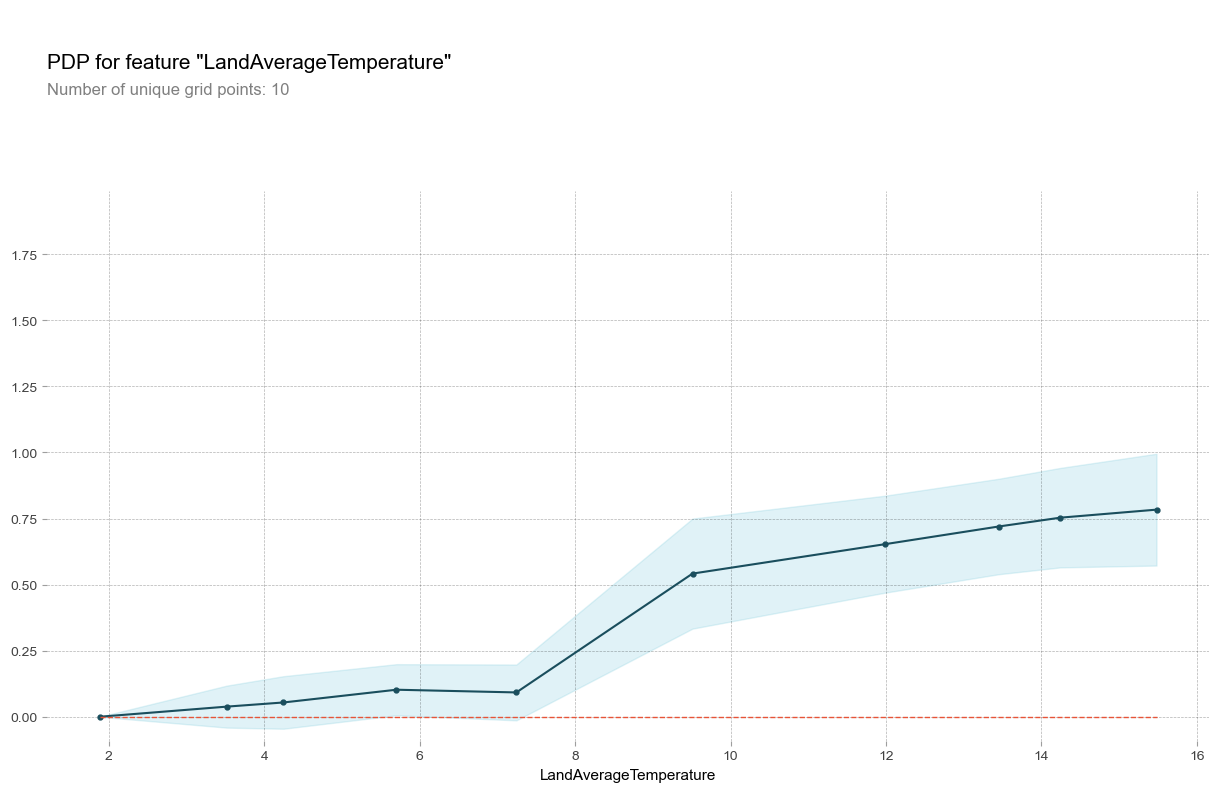

In [50]:
from pdpbox.pdp import pdp_isolate, pdp_plot
feature ='LandAverageTemperature'
isolated = pdp_isolate(model = forestModel, 
                       dataset =X_val, 
                       model_features=X_val.columns,
                       feature = feature)
pdp_plot(isolated, feature_name=feature)

## In This Part I am going to use the Sequence Model To Predict the average global land Temperature

In [122]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as scatter 

In [130]:
gltemp = pd.read_csv("GlobalTemperatures.csv")
#Print Dataframe shape
gltemp.shape
gltemp.columns

Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')

In [131]:
def DataClean(df):
    df = df.copy()
    #Cleaning the dataset from unused column
    df = df.drop(columns=['LandAverageTemperatureUncertainty','LandMaxTemperatureUncertainty','LandMinTemperatureUncertainty','LandAndOceanAverageTemperatureUncertainty'], axis=1)
    #Convert Teamperature Data
    df['LandAverageTemperature'] = df['LandAverageTemperature'].apply(convertTemp)
    df['LandMaxTemperature']=df ['LandMaxTemperature'].apply(convertTemp)
    df['LandMinTemperature']=df ['LandMinTemperature'].apply(convertTemp)
    df['LandAndOceanAverageTemperature']=df ['LandAndOceanAverageTemperature'].apply(convertTemp)
    
    #drop NaN values
    df= df.dropna()
    return df

In [132]:
gltemp = DataClean(gltemp)
#Print The 5th first Columns to show Modification
globaltemp.head()

,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature
Year,,,,
1950,2.008,7.611,-3.622,13.311
1950,2.721,8.475,-3.013,13.554
1950,5.247,11.173,-0.693,14.296
1950,8.123,14.157,2.043,15.093
1950,11.297,17.252,5.421,16.033


In [129]:
#Identify Anomalies/ Missing Data
globaltemp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792 entries, 1950 to 2015
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   LandAverageTemperature          792 non-null    float64
 1   LandMaxTemperature              792 non-null    float64
 2   LandMinTemperature              792 non-null    float64
 3   LandAndOceanAverageTemperature  792 non-null    float64
dtypes: float64(4)
memory usage: 30.9 KB


In [107]:
#Model
model = Sequential()
model.add(Dense(64, input_dim = X_train.shape[1],activation='relu'))
model.add(Dense(10))

#Compiling the neural network
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'] )

#Fitting the data to the training dataset  
model.fit(X_train,Y_train, batch_size=64, epochs=100, verbose=0)

#configure the model of training 
history = model.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1161 - accuracy: 0.0000e+00
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1160 - accuracy: 0.0000e+00
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1156 - accuracy: 0.0000e+00
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1155 - accuracy: 0.0000e+00
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1152 - accuracy: 0.0000e+00
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1155 - accuracy: 0.0000e+00
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1149 - accuracy: 0.0000e+00
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1150 - accuracy: 0.0000e+00
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1147 - accuracy: 0.0000e+00
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss:

19/19 [==============================] - 0s 3ms/step - loss: 0.1099 - accuracy: 0.0000e+00
Epoch 80/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1098 - accuracy: 0.0000e+00
Epoch 81/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1106 - accuracy: 0.0000e+00
Epoch 82/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1116 - accuracy: 0.0000e+00
Epoch 83/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1098 - accuracy: 0.0000e+00
Epoch 84/100
19/19 [==============================] - 0s 4ms/step - loss: 0.1094 - accuracy: 0.0000e+00
Epoch 85/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1098 - accuracy: 0.0000e+00
Epoch 86/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1098 - accuracy: 0.0000e+00
Epoch 87/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1096 - accuracy: 0.0000e+00
Epoch 88/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1

In [108]:
accuracy = model.evaluate(X_val, Y_val)

7/7 [==============================] - 0s 3ms/step - loss: 0.1070 - accuracy: 0.0000e+00


In [109]:
print("Accuracy: {:.2f}%",accuracy )

Accuracy: {:.2f}% [0.10697154700756073, 0.0]


In [110]:
prediction = model.predict(X_val)

7/7 [==============================] - 0s 3ms/step


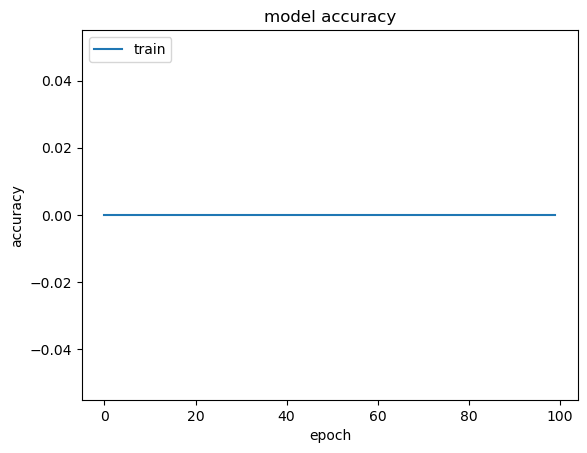

In [111]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

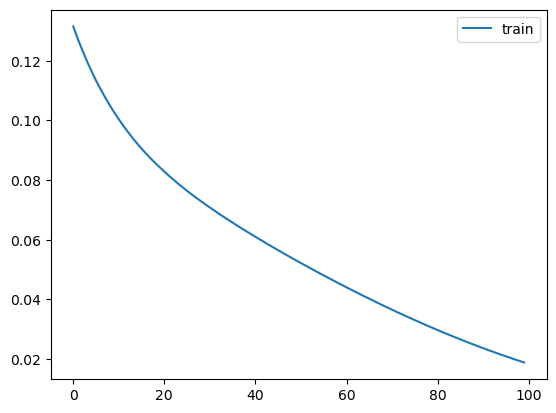

In [97]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [135]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_val)
# invert predictions
train_Predict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([Y_train])
test_Predict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([Y_val])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(Y_train[0], train_Predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(Y_val[0], test_Predict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

7/7 [==============================] - 0s 3ms/step


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.